# **Segmentación Estratégica de Clientes B2B**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/renatslarg/machine-learning-comparison-of-clustering-models /blob/main/Analisis_y_Segmentacion_de_Clientes.ipynb)

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from math import pi
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [44]:
# -*- coding: utf-8 -*-
# -----------------------------------------------------------------------------
# PASO 1: IMPORTAR LIBRERÍAS Y CARGAR DATOS
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
from google.colab import drive

print("Librerías importadas correctamente.")

try:
    # Montamos Google Drive
    drive.mount('/content/drive')
    print("\nGoogle Drive montado con éxito.")


    # Asegúrate de que esta ruta apunte a tu ARCHIVO en Google Drive.
    #file_path = '/content/drive/MyDrive/Business Intelligence & Insights/Clasificador clientes/dataset_clientes.csv'
    file_path = '/content/drive/MyDrive/dataset_clientes.csv'
    # -----------------------------------------

    print(f"Intentando cargar el archivo desde: {file_path}")
    df = pd.read_csv(file_path, sep=',', encoding='latin1')
    print("\nArchivo anonimizado cargado exitosamente.")

    print("\nInformación inicial del dataset de campañas:")
    df.info()
    print("\nVista previa de los datos:")
    print(df.head())

except Exception as e:
    print(f"\nOcurrió un error al cargar el archivo: {e}")
    raise



Librerías importadas correctamente.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Google Drive montado con éxito.
Intentando cargar el archivo desde: /content/drive/MyDrive/dataset_clientes.csv


/tmp/ipython-input-1139535355.py:23: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',', encoding='latin1')



Archivo anonimizado cargado exitosamente.

Información inicial del dataset de campañas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711214 entries, 0 to 711213
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             711213 non-null  object 
 1   month            711213 non-null  object 
 2   costo_medio      711212 non-null  float64
 3   campaign_id      711213 non-null  object 
 4   campaign_name    711214 non-null  object 
 5   agency           711214 non-null  object 
 6   purchase_mode    691552 non-null  object 
 7   business_type    709076 non-null  object 
 8   sales_country    711132 non-null  object 
 9   brand            711214 non-null  object 
 10  inversion        711213 non-null  float64
 11  rebates          711213 non-null  float64
 12  margin_neto      711213 non-null  float64
 13   family format   708492 non-null  object 
dtypes: float64(4), object(10)
memory usage: 76.

In [45]:
# --- CÓDIGO DE DIAGNÓSTICO AÑADIDO ---
# Antes de eliminar, vamos a investigar cuántos nulos hay.
print("\n--- Diagnóstico de Valores Nulos (Antes de la eliminación) ---")
columnas_criticas = ['date', 'agency', 'sales_country', 'inversion', 'margin_neto']
nulos_por_columna = df[columnas_criticas].isnull().sum()
print("Cantidad de nulos por columna crítica:")
print(nulos_por_columna)
print("----------------------------------------------------")
# --- FIN DEL CÓDIGO DE DIAGNÓSTICO ---


# --- Manejo de Nulos ---
# Eliminamos filas donde la fecha no se pudo convertir o donde faltan datos clave.
filas_antes = len(df)
df.dropna(subset=['date', 'agency', 'sales_country', 'inversion', 'margin_neto'], inplace=True)
filas_despues = len(df)
print(f"  - Se eliminaron {filas_antes - filas_despues} filas con valores nulos en columnas críticas.")





--- Diagnóstico de Valores Nulos (Antes de la eliminación) ---
Cantidad de nulos por columna crítica:
date              1
agency            0
sales_country    82
inversion         1
margin_neto       1
dtype: int64
----------------------------------------------------
  - Se eliminaron 82 filas con valores nulos en columnas críticas.


In [46]:
# -----------------------------------------------------------------------------
# PASO 2: LIMPIEZA Y PREPARACIÓN INICIAL
# -----------------------------------------------------------------------------
print("\nIniciando limpieza y preparación de datos...")

# --- CORRECCIÓN DEL ERROR ---
# A menudo, los CSV tienen espacios extra en los nombres de las columnas.
# Esta línea los elimina para evitar KeyErrors.
df.columns = df.columns.str.strip()

# Para depuración, imprimimos las columnas encontradas para verificar los nombres
print("\nColumnas encontradas en el archivo (después de limpiar espacios):")
print(df.columns.tolist())
# ---------------------------

df['date'] = pd.to_datetime(df['date'], errors='coerce')
columnas_criticas = ['date', 'agency', 'sales_country', 'inversion', 'margin_neto', 'rebates']
df.dropna(subset=columnas_criticas, inplace=True)

# Nos aseguramos de que las columnas a concatenar sean de tipo string.
df['agency'] = df['agency'].astype(str)
df['sales_country'] = df['sales_country'].astype(str)

df['id_cliente'] = df['agency'] + '_' + df['sales_country']
print("  - Limpieza y preparación inicial completadas.")



Iniciando limpieza y preparación de datos...

Columnas encontradas en el archivo (después de limpiar espacios):
['date', 'month', 'costo_medio', 'campaign_id', 'campaign_name', 'agency', 'purchase_mode', 'business_type', 'sales_country', 'brand', 'inversion', 'rebates', 'margin_neto', 'family format']
  - Limpieza y preparación inicial completadas.


In [47]:
# -----------------------------------------------------------------------------
# PASO 3: INGENIERÍA DE VARIABLES (FEATURE ENGINEERING)
# -----------------------------------------------------------------------------
print("\nIniciando la transformación de datos de campañas a datos de clientes...")

# Definimos 'hoy' como la fecha más reciente en el dataset + 1 día para asegurar
# que todos los cálculos de antigüedad sean consistentes y reproducibles.
hoy = df['date'].max() + pd.Timedelta(days=1)
print(f"  - Fecha de referencia para cálculos de antigüedad: {hoy.strftime('%Y-%m-%d')}")

# Clean up column names by stripping whitespace
df.columns = df.columns.str.strip()
print("  - Stripped whitespace from column names.")

# Rename the column 'family format' to 'family_format'
df.rename(columns={'family format': 'family_format'}, inplace=True)
print("  - Renamed column 'family format' to 'family_format'.")


# --- Agregación de datos ---
# Usamos .groupby('id_cliente') para realizar cálculos para cada cliente.
df_clientes = df.groupby('id_cliente').agg(

    # 1. Antigüedad de la Relación (en días)
    AntiguedadRelacion=('date', lambda x: (hoy - x.min()).days),

    # 2. Inversión Promedio por Campana
    AvgInversionPorCampana=('inversion', 'mean'),

    # 3. Diversidad de Marcas
    DiversidadMarcas=('brand', 'nunique'),

    # 4. Diversidad de Formatos
    DiversidadFormatos=('family_format', 'nunique'),

    # 5. Margen Promedio
    AvgMargen=('margin_neto', 'mean')

).reset_index()

print("  - Variables de perfil calculadas (Antigüedad, Promedios, Diversidad).")

# --- Cálculo de Tasa de Comisión Promedio ---
comisiones_df = df.groupby('id_cliente').agg(
    TotalInversionHistorica=('inversion', 'sum'),
    TotalComisionHistorica=('rebates', 'sum')
).reset_index()

# Calculamos la tasa de comisión promedio, manejando la división por cero.
comisiones_df['TasaComisionPromedio'] = (comisiones_df['TotalComisionHistorica'] / comisiones_df['TotalInversionHistorica']).fillna(0)
print("  - Nueva variable 'TasaComisionPromedio' calculada.")

# --- Cálculos basados en los últimos 12 meses ---
# Filtramos el dataset para incluir solo el último año de datos.
df_ultimos_12m = df[df['date'] >= (hoy - pd.DateOffset(months=12))]

# Calculamos las métricas anualizadas
inversion_12m = df_ultimos_12m.groupby('id_cliente')['inversion'].sum().reset_index()
inversion_12m.rename(columns={'inversion': 'VolumenInversion_12M'}, inplace=True)

margen_12m = df_ultimos_12m.groupby('id_cliente')['margin_neto'].sum().reset_index()
margen_12m.rename(columns={'margin_neto': 'MargenTotal_12M'}, inplace=True)

print("  - Variables de valor calculadas (Inversión y Margen de los últimos 12 meses).")

# --- Unimos todo en un único DataFrame de clientes ---
df_clientes = pd.merge(df_clientes, comisiones_df[['id_cliente', 'TasaComisionPromedio']], on='id_cliente', how='left')
df_clientes = pd.merge(df_clientes, inversion_12m, on='id_cliente', how='left')
df_clientes = pd.merge(df_clientes, margen_12m, on='id_cliente', how='left')

# Rellenamos con 0 los clientes que no tuvieron actividad en los últimos 12 meses
df_clientes.fillna(0, inplace=True)

print("  - Se ha creado el DataFrame final de clientes.")


Iniciando la transformación de datos de campañas a datos de clientes...
  - Fecha de referencia para cálculos de antigüedad: 2025-12-07
  - Stripped whitespace from column names.
  - Renamed column 'family format' to 'family_format'.
  - Variables de perfil calculadas (Antigüedad, Promedios, Diversidad).
  - Nueva variable 'TasaComisionPromedio' calculada.
  - Variables de valor calculadas (Inversión y Margen de los últimos 12 meses).
  - Se ha creado el DataFrame final de clientes.


In [48]:
# -----------------------------------------------------------------------------
# PASO 4: VERIFICACIÓN DEL DATASET DE CLIENTES
# -----------------------------------------------------------------------------

df_clientes.info()

print("\nVista previa del DataFrame de clientes:")
print(df_clientes.head())

print("\nEstadísticas descriptivas del DataFrame de clientes:")
print(df_clientes.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              1005 non-null   object 
 1   AntiguedadRelacion      1005 non-null   int64  
 2   AvgInversionPorCampana  1005 non-null   float64
 3   DiversidadMarcas        1005 non-null   int64  
 4   DiversidadFormatos      1005 non-null   int64  
 5   AvgMargen               1005 non-null   float64
 6   TasaComisionPromedio    1005 non-null   float64
 7   VolumenInversion_12M    1005 non-null   float64
 8   MargenTotal_12M         1005 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 70.8+ KB

Vista previa del DataFrame de clientes:
             id_cliente  AntiguedadRelacion  AvgInversionPorCampana  \
0     agency_100_Brasil                1004               79.479048   
1    agency_100_EspaÃ±a                1071               76.0901

In [49]:
# -----------------------------------------------------------------------------
# PASO 5: SEGMENTACIÓN ESTRATÉGICA: ACTIVOS VS. INACTIVOS
# -----------------------------------------------------------------------------
print("\n--- INICIANDO SEGMENTACIÓN ESTRATÉGICA PREVIA ---")
print("Separando clientes activos de inactivos para un análisis más preciso.")

# Clientes inactivos son aquellos que no han tenido inversión en los últimos 12 meses.
df_inactivos = df_clientes[df_clientes['VolumenInversion_12M'] == 0].copy()
df_inactivos['Cluster'] = 'Inactivos' # Les asignamos su propio segmento

# Clientes activos son el resto. Sobre este grupo haremos el clustering.
df_activos = df_clientes[df_clientes['VolumenInversion_12M'] > 0].copy()

print(f"\nTotal de clientes: {len(df_clientes)}")
print(f"  - Clientes Activos (Inversión > 0 en 12M): {len(df_activos)}")
print(f"  - Clientes Inactivos (Inversión = 0 en 12M): {len(df_inactivos)}")
print("\nEl análisis de clustering y EDA se realizará sobre el grupo de CLIENTES ACTIVOS.")


--- INICIANDO SEGMENTACIÓN ESTRATÉGICA PREVIA ---
Separando clientes activos de inactivos para un análisis más preciso.

Total de clientes: 1005
  - Clientes Activos (Inversión > 0 en 12M): 341
  - Clientes Inactivos (Inversión = 0 en 12M): 664

El análisis de clustering y EDA se realizará sobre el grupo de CLIENTES ACTIVOS.



--- INICIANDO ANÁLISIS EXPLORATORIO DE DATOS (EDA) SOBRE CLIENTES ACTIVOS ---

Generando histogramas de las variables clave (solo activos)...


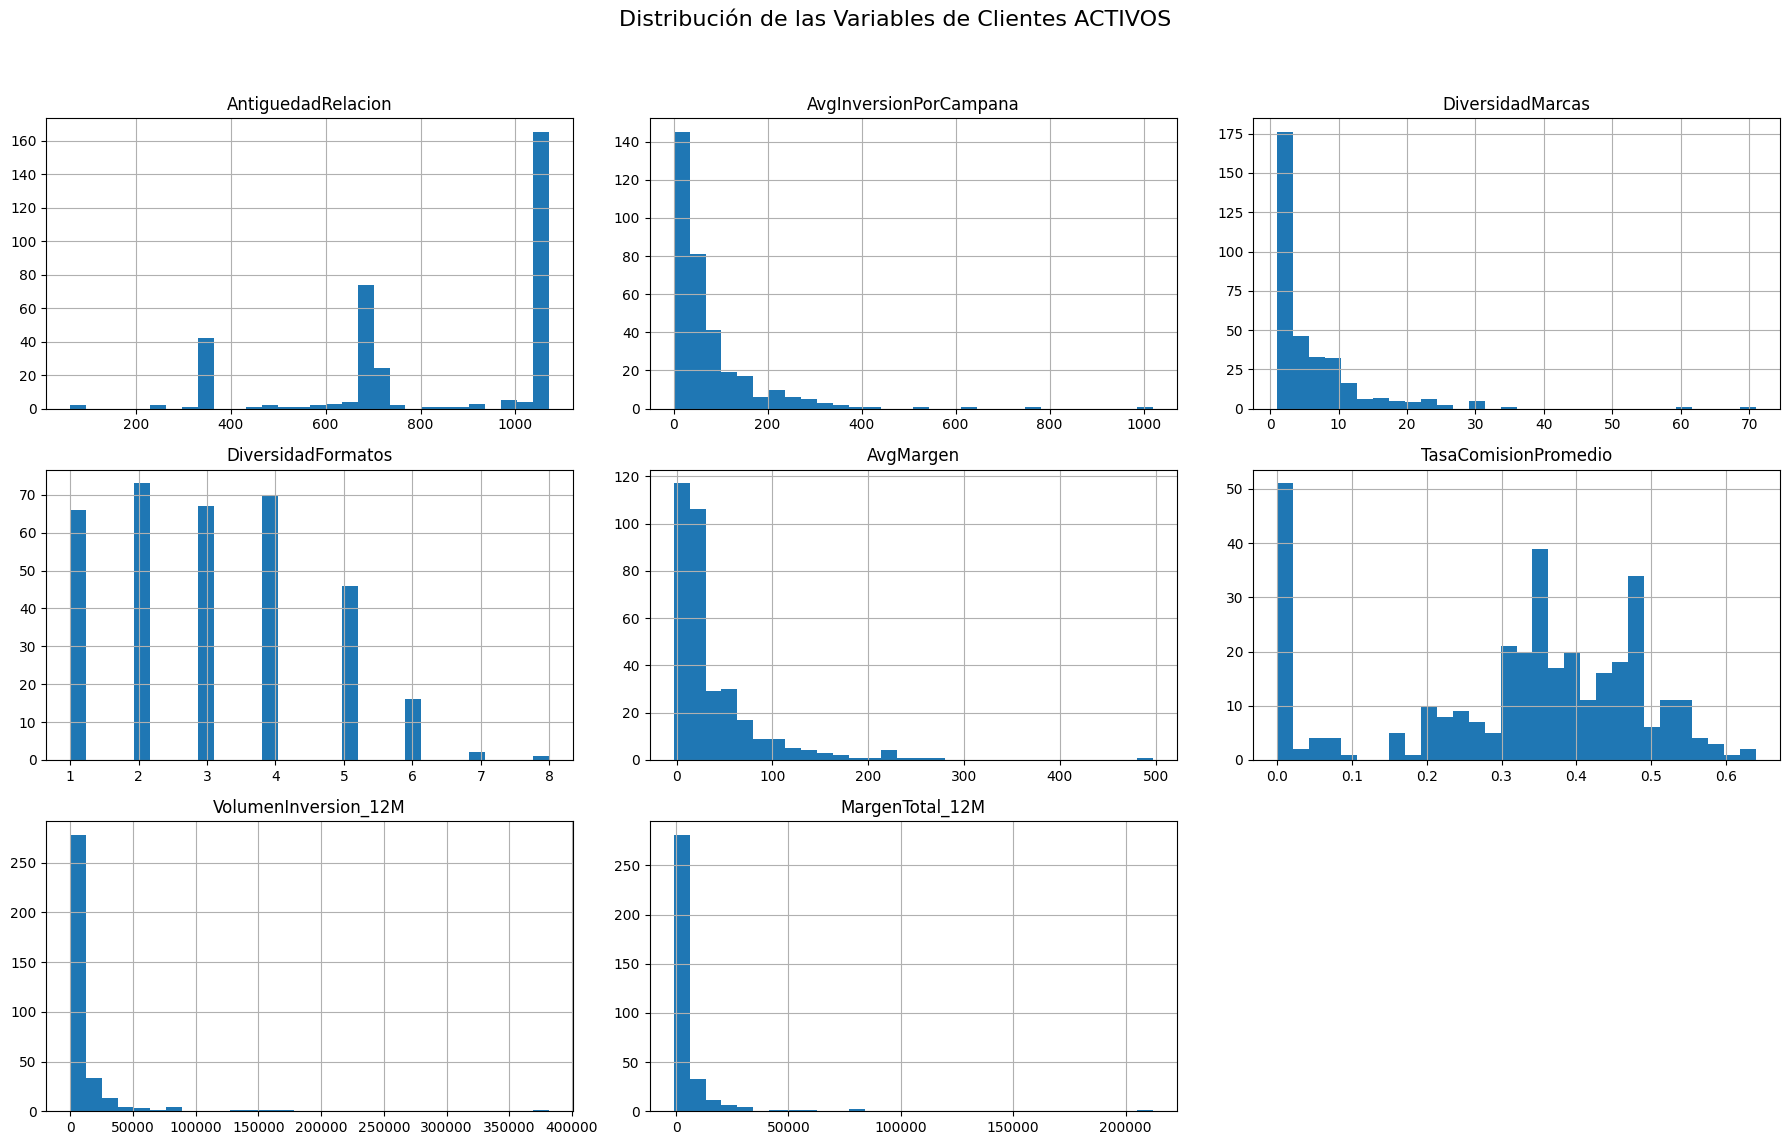

In [50]:
# -----------------------------------------------------------------------------
# PASO 6: ANÁLISIS EXPLORATORIO DE DATOS (EDA) SOBRE CLIENTES ACTIVOS
# -----------------------------------------------------------------------------
print("\n--- INICIANDO ANÁLISIS EXPLORATORIO DE DATOS (EDA) SOBRE CLIENTES ACTIVOS ---")

# Seleccionamos solo las columnas numéricas para el análisis (excluyendo el ID)
# Ahora usamos df_activos
df_analisis = df_activos.drop('id_cliente', axis=1)

# --- 1. Histogramas para ver la distribución de cada variable ---
print("\nGenerando histogramas de las variables clave (solo activos)...")
df_analisis.hist(bins=30, figsize=(18, 12)) # Aumentamos el tamaño para la nueva variable
plt.suptitle('Distribución de las Variables de Clientes ACTIVOS', size=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Generando boxplots para identificar outliers...


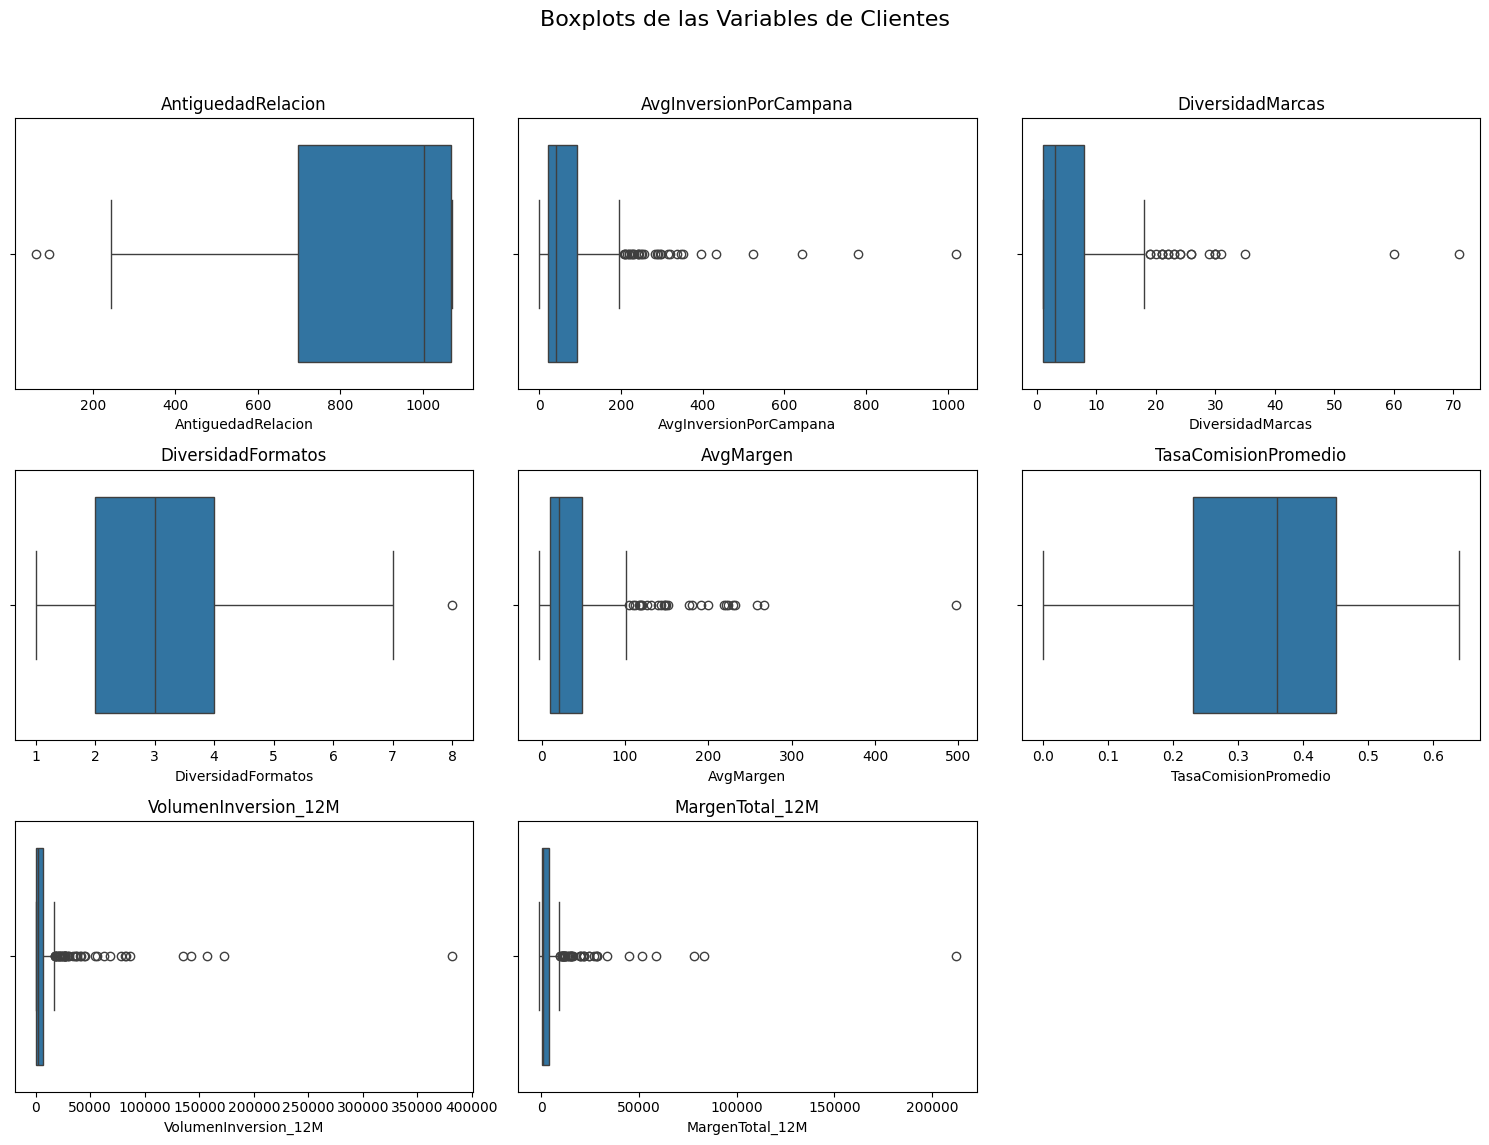

In [51]:
# --- 2. Boxplots para identificar outliers ---
print("\nGenerando boxplots para identificar outliers...")
# Trazamos un boxplot para cada columna en un subgráfico separado
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Boxplots de las Variables de Clientes', size=16)
axes = axes.flatten() # Convertimos la matriz de ejes en una lista plana

for i, col in enumerate(df_analisis.columns):
    sns.boxplot(x=df_analisis[col], ax=axes[i])
    axes[i].set_title(col)

# Ocultamos los ejes que no se usan si el número de variables es menor que 9
for j in range(len(df_analisis.columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [52]:
# --- 4. Investigación de Outliers Específicos ---
print("\n--- INVESTIGACIÓN DE OUTLIERS ESPECÍFICOS ---")

# Encontrar el cliente con la mayor diversidad de marcas
try:
    cliente_top_marcas = df_activos.loc[df_activos['DiversidadMarcas'].idxmax()]
    print("\nAnálisis del cliente con la mayor cantidad de marcas:")
    # Usamos .to_frame().T para mostrarlo de forma más legible
    print(cliente_top_marcas.to_frame().T)
except ValueError:
    print("\nNo se encontraron clientes activos para analizar el outlier de DiversidadMarcas.")


#  queremos ver los clientes con más de N marcas (ej. más de 40)
clientes_muchas_marcas = df_activos[df_activos['DiversidadMarcas'] > 40]
if not clientes_muchas_marcas.empty:
    print("\nClientes que trabajan con más de 40 marcas:")
    print(clientes_muchas_marcas)
else:
    print("\nNo se encontraron otros clientes que trabajen con más de 40 marcas.")



--- INVESTIGACIÓN DE OUTLIERS ESPECÍFICOS ---

Análisis del cliente con la mayor cantidad de marcas:
              id_cliente AntiguedadRelacion AvgInversionPorCampana  \
13  agency_108_Guatemala               1071              26.923363   

   DiversidadMarcas DiversidadFormatos  AvgMargen TasaComisionPromedio  \
13               71                  5  15.626208              0.06995   

   VolumenInversion_12M MargenTotal_12M  
13            3185.2012       1999.1302  

Clientes que trabajan con más de 40 marcas:
              id_cliente  AntiguedadRelacion  AvgInversionPorCampana  \
13  agency_108_Guatemala                1071               26.923363   
55      agency_13_Brasil                1071               85.171135   

    DiversidadMarcas  DiversidadFormatos  AvgMargen  TasaComisionPromedio  \
13                71                   5  15.626208              0.069950   
55                60                   4  45.904992              0.333781   

    VolumenInversion_12M  Marg


Generando matriz de correlación...


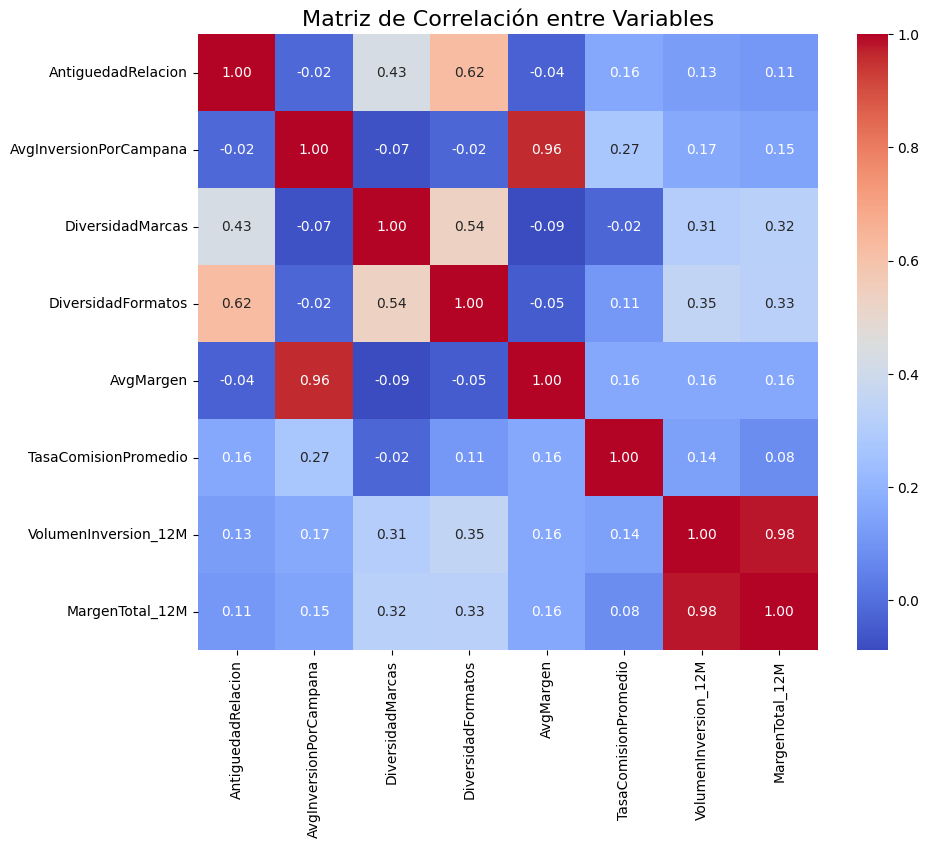

In [53]:
# --- 3. Matriz de Correlación para ver la relación entre variables ---
print("\nGenerando matriz de correlación...")
plt.figure(figsize=(10, 8))
correlation_matrix = df_analisis.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables', size=16)
plt.show()

In [54]:
# -----------------------------------------------------------------------------
# PASO 7: PREPROCESAMIENTO Y MODELADO CON K-MEANS
# -----------------------------------------------------------------------------
print("\n--- INICIANDO PREPROCESAMIENTO Y MODELADO ---")

# --- 7.1. Selección de Variables ---
# Basado en la matriz de correlación, eliminamos las variables redundantes.
features_df = df_activos.drop([
    'id_cliente',
    'AvgMargen',              # Redundante con AvgInversionPorCampana
    'MargenTotal_12M'         # Redundante con VolumenInversion_12M
], axis=1)
print(f"  - Variables seleccionadas para el modelo: {list(features_df.columns)}")





--- INICIANDO PREPROCESAMIENTO Y MODELADO ---
  - Variables seleccionadas para el modelo: ['AntiguedadRelacion', 'AvgInversionPorCampana', 'DiversidadMarcas', 'DiversidadFormatos', 'TasaComisionPromedio', 'VolumenInversion_12M']


In [55]:
# --- 7.2. Transformación Logarítmica ---
# Aplicamos logaritmo natural + 1 (para evitar log(0)) a las variables asimétricas.
# Esto reduce el impacto de los outliers y normaliza las distribuciones.
log_features_df = features_df.copy()
columnas_asimetricas = [
    'AntiguedadRelacion', 'AvgInversionPorCampana', 'DiversidadMarcas',
    'DiversidadFormatos', 'VolumenInversion_12M'
]

for col in columnas_asimetricas:
    log_features_df[col] = np.log1p(log_features_df[col])

print("  - Transformación logarítmica aplicada a variables asimétricas.")




  - Transformación logarítmica aplicada a variables asimétricas.


In [56]:
# --- 7.3. Escalado de Datos ---
# Estandarizamos todas las variables para que tengan media 0 y desviación estándar 1.
# para que K-Means funcione correctamente.


scaler = StandardScaler()
scaled_features = scaler.fit_transform(log_features_df)
scaled_features_df = pd.DataFrame(scaled_features, columns=log_features_df.columns)
print("  - Todas las variables han sido estandarizadas.")

  - Todas las variables han sido estandarizadas.



Calculando el número óptimo de clusters (esto puede tardar un momento)...


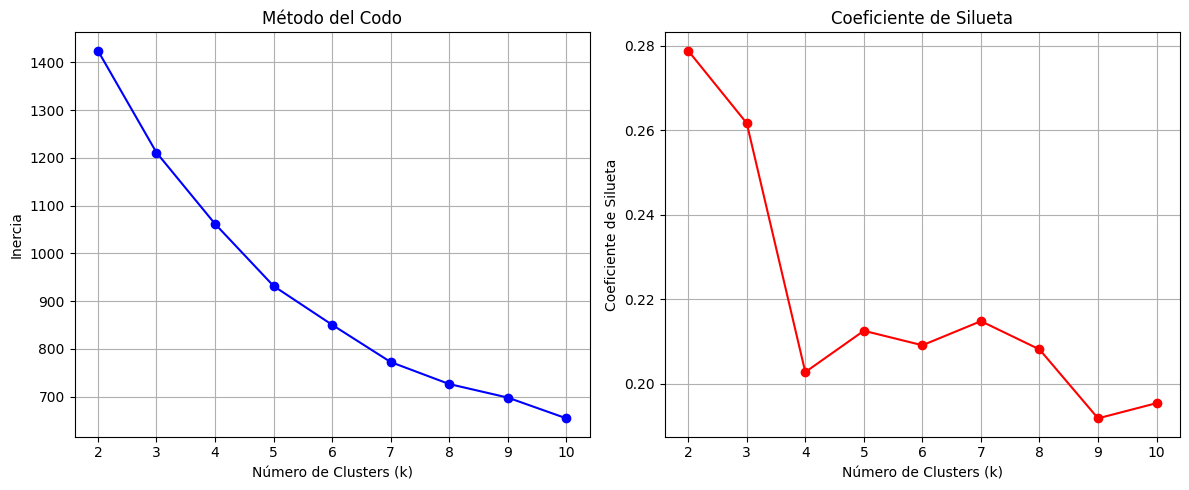


--- ANÁLISIS DE GRÁFICOS ---
  - Método del Codo: Busca el 'codo' en la curva, el punto donde la línea deja de caer tan bruscamente.
  - Coeficiente de Silueta: Busca el valor MÁS ALTO. Un valor más alto indica clusters más densos y mejor separados.


In [57]:
# --- 7.4. Búsqueda del Número Óptimo de Clusters (k) ---
print("\nCalculando el número óptimo de clusters (esto puede tardar un momento)...")

inertia = []
silhouette_scores = []
K = range(2, 11)  # Probaremos de 2 a 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(scaled_features_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

# Gráfico del Método del Codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

# Gráfico del Coeficiente de Silueta
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- ANÁLISIS DE GRÁFICOS ---")
print("  - Método del Codo: Busca el 'codo' en la curva, el punto donde la línea deja de caer tan bruscamente.")
print("  - Coeficiente de Silueta: Busca el valor MÁS ALTO. Un valor más alto indica clusters más densos y mejor separados.")

In [58]:
# --- 7.5. Entrenamiento del Modelo Final y Asignación de Clusters ---
# Basado en el análisis de los gráficos, elegimos el número de clusters.
# El Método del Codo muestra un punto de inflexión claro en k=4, que ofrece una
# buena granularidad para el negocio, aunque el Coeficiente de Silueta sea mayor para k=2.
k_optimo = 4
print(f"\nEntrenando el modelo final con k = {k_optimo} clusters...")

kmeans_final = KMeans(n_clusters=k_optimo, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans_final.fit(scaled_features_df)

# Asignamos la etiqueta del cluster a cada cliente activo
df_activos['Cluster'] = kmeans_final.labels_
print("  - Clusters asignados a los clientes activos.")

print("\nVista previa de los clientes activos con su cluster asignado:")
print(df_activos.head())



Entrenando el modelo final con k = 4 clusters...
  - Clusters asignados a los clientes activos.

Vista previa de los clientes activos con su cluster asignado:
             id_cliente  AntiguedadRelacion  AvgInversionPorCampana  \
2     agency_101_Brasil                1071                8.267623   
3  agency_102_Argentina                1070               17.451225   
4     agency_102_Brasil                 696               11.395541   
5      agency_102_Chile                1063               72.688234   
6    agency_102_EspaÃ±a                1071              336.410843   

   DiversidadMarcas  DiversidadFormatos   AvgMargen  TasaComisionPromedio  \
2                 2                   3    4.617229              0.360000   
3                 8                   4    7.609913              0.373354   
4                 3                   2    5.560360              0.360000   
5                 3                   4   38.340202              0.188385   
6                13         

In [59]:
# --- 7.6. Evaluación del Modelo Final ---
print("\n--- EVALUACIÓN DEL MODELO DE CLUSTERING FINAL ---")
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Inercia: Suma de las distancias al cuadrado de las muestras a su centro de cluster más cercano. Menor es mejor.
inertia_final = kmeans_final.inertia_
print(f"  - Inercia final (WCSS): {inertia_final:.2f}")

# Coeficiente de Silueta: Mide qué tan similar es un objeto a su propio cluster en comparación con otros clusters. Rango [-1, 1]. Mayor es mejor.
silhouette_final = silhouette_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Coeficiente de Silueta: {silhouette_final:.3f}")

# Índice de Calinski-Harabasz: Ratio entre la dispersión entre clusters y la dispersión intra-cluster. Mayor es mejor.
calinski_harabasz = calinski_harabasz_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Índice de Calinski-Harabasz: {calinski_harabasz:.2f}")

# Índice de Davies-Bouldin: Promedio de la 'similitud' de cada cluster con su cluster más similar. Menor es mejor (cercano a 0).
davies_bouldin = davies_bouldin_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Índice de Davies-Bouldin: {davies_bouldin:.3f}")


--- EVALUACIÓN DEL MODELO DE CLUSTERING FINAL ---
  - Inercia final (WCSS): 1061.95
  - Coeficiente de Silueta: 0.203
  - Índice de Calinski-Harabasz: 104.09
  - Índice de Davies-Bouldin: 1.465


In [60]:
# -----------------------------------------------------------------------------
# PASO 8: INTERPRETACIÓN Y PERFILADO DE CLUSTERS
# -----------------------------------------------------------------------------
print("\n--- INICIANDO INTERPRETACIÓN Y PERFILADO DE CLUSTERS ---")

# Calculamos el valor promedio de cada variable para cada cluster.
# Excluir la columna 'id_cliente' que es de tipo object
cluster_profile = df_activos.groupby('Cluster').mean(numeric_only=True)
print("\nPerfil numérico de cada cluster (valores promedio):")
print(cluster_profile)


--- INICIANDO INTERPRETACIÓN Y PERFILADO DE CLUSTERS ---

Perfil numérico de cada cluster (valores promedio):
         AntiguedadRelacion  AvgInversionPorCampana  DiversidadMarcas  \
Cluster                                                                 
0                632.206612               90.746821          1.677686   
1               1010.404255               30.494326         10.106383   
2                999.569767              138.929601          9.558140   
3                657.600000               11.337725          2.275000   

         DiversidadFormatos  AvgMargen  TasaComisionPromedio  \
Cluster                                                        
0                  1.834711  47.989946              0.362133   
1                  4.148936  15.158426              0.270322   
2                  4.174419  65.186696              0.426903   
3                  1.750000   7.975258              0.068511   

         VolumenInversion_12M  MargenTotal_12M  
Cluster         

In [61]:
# --- Ratio Esfuerzo/Rendimiento ---
# Calculamos cuánto margen se genera por cada marca gestionada.
# Un valor bajo indica un "alto esfuerzo" para un "bajo rendimiento".
cluster_profile['MargenPorMarca'] = cluster_profile['MargenTotal_12M'] / cluster_profile['DiversidadMarcas']
print("\nPerfil numérico de cada cluster (valores promedio):")
print(cluster_profile)



Perfil numérico de cada cluster (valores promedio):
         AntiguedadRelacion  AvgInversionPorCampana  DiversidadMarcas  \
Cluster                                                                 
0                632.206612               90.746821          1.677686   
1               1010.404255               30.494326         10.106383   
2                999.569767              138.929601          9.558140   
3                657.600000               11.337725          2.275000   

         DiversidadFormatos  AvgMargen  TasaComisionPromedio  \
Cluster                                                        
0                  1.834711  47.989946              0.362133   
1                  4.148936  15.158426              0.270322   
2                  4.174419  65.186696              0.426903   
3                  1.750000   7.975258              0.068511   

         VolumenInversion_12M  MargenTotal_12M  MargenPorMarca  
Cluster                                                   

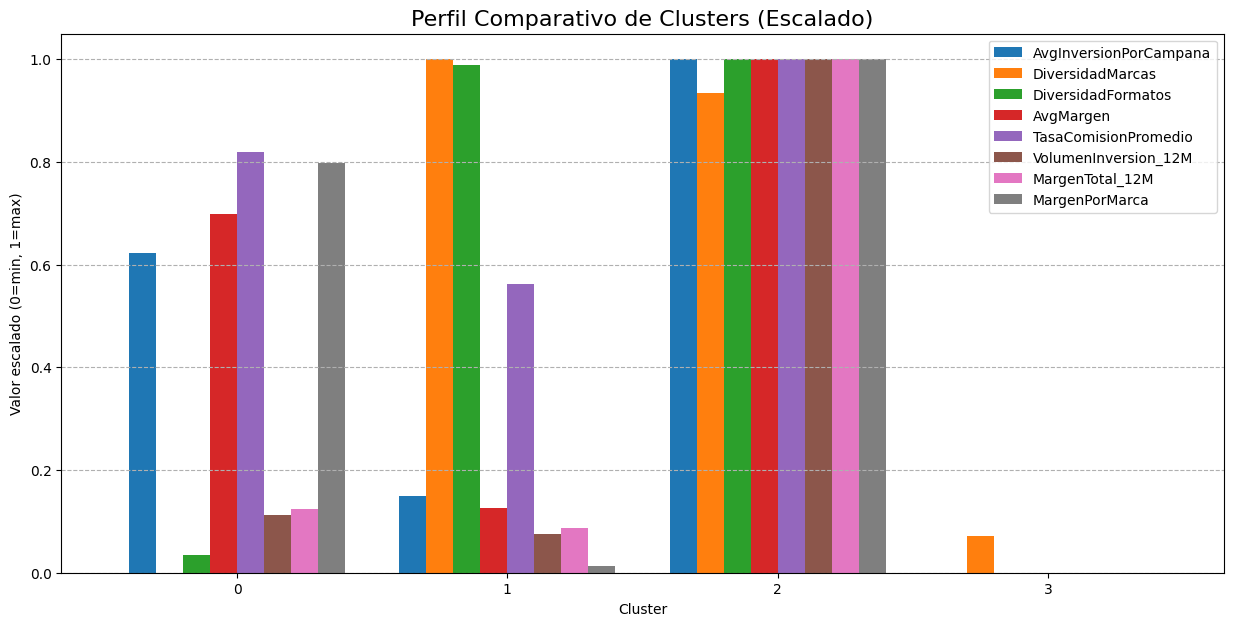

In [62]:
# --- Visualización de los Clusters ---


scaler_viz = MinMaxScaler()
# Ahora incluimos la nueva métrica en la visualización
profile_to_scale = cluster_profile.drop('AntiguedadRelacion', axis=1)
profile_scaled = scaler_viz.fit_transform(profile_to_scale)
profile_scaled_df = pd.DataFrame(profile_scaled, index=profile_to_scale.index, columns=profile_to_scale.columns)
# Gráfico de Barras Comparativo
profile_scaled_df.plot(kind='bar', figsize=(15, 7), width=0.8)
plt.title('Perfil Comparativo de Clusters (Escalado)', size=16)
plt.ylabel('Valor escalado (0=min, 1=max)')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--')
plt.show()

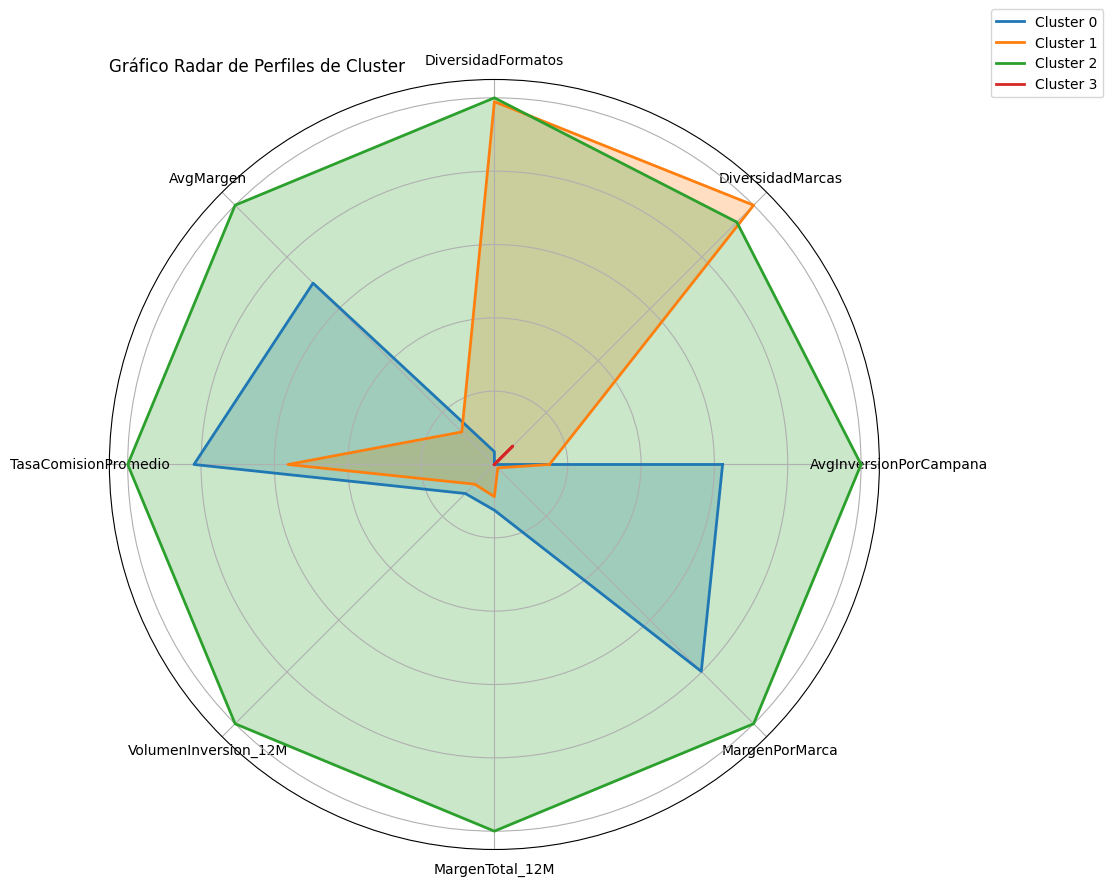


Conteo de clientes por cada segmento:
Cluster
0    121
1     94
2     86
3     40
Name: count, dtype: int64


In [63]:
# Gráfico Radar

categories = list(profile_scaled_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for i in range(len(profile_scaled_df)):
    values = profile_scaled_df.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {profile_scaled_df.index[i]}")
    ax.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories)
ax.set_yticklabels([])
plt.title('Gráfico Radar de Perfiles de Cluster', size=12, loc='left')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

# --- Conteo de clientes por cluster ---
print("\nConteo de clientes por cada segmento:")
print(df_activos['Cluster'].value_counts().sort_index())

In [64]:
# --- 7.5. Entrenamiento del Modelo Final con Hiperparámetros Ajustados (K-Means) ---
k_optimo = 4
print(f"\nEntrenando el modelo K-Means final con k = {k_optimo} clusters y hiperparámetros ajustados...")

# Ajuste de Hiperparámetros:
# n_clusters: Se eligió k=4 basándose en el análisis del Método del Codo y la interpretabilidad de negocio.
# init: Se utiliza 'k-means++', un método inteligente para inicializar los centroides que acelera la convergencia y mejora la calidad del resultado final.
# n_init: Se aumenta a 25 (el valor por defecto es 10). Esto hace que el algoritmo se ejecute 25 veces con diferentes centroides iniciales, eligiendo el mejor resultado. Aumenta la robustez del modelo.
# max_iter: Se mantiene en 300, que es el número máximo de iteraciones por cada ejecución. Es un valor estándar suficiente para que el algoritmo converja.
# random_state: Se fija en 42 para garantizar que los resultados sean reproducibles.
kmeans_final = KMeans(
    n_clusters=k_optimo,
    init='k-means++',
    n_init=25,
    max_iter=300,
    random_state=42
)

kmeans_final.fit(scaled_features_df)
df_activos['Cluster_KMeans'] = kmeans_final.labels_
print("  - Clusters de K-Means asignados a los clientes activos.")


# --- 7.6. Evaluación del Modelo Final K-Means ---
print("\n--- EVALUACIÓN DEL MODELO K-MEANS FINAL ---")
inertia_final = kmeans_final.inertia_
print(f"  - Inercia final (WCSS): {inertia_final:.2f}")
silhouette_final = silhouette_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Coeficiente de Silueta: {silhouette_final:.3f}")
calinski_harabasz = calinski_harabasz_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Índice de Calinski-Harabasz: {calinski_harabasz:.2f}")
davies_bouldin = davies_bouldin_score(scaled_features_df, kmeans_final.labels_)
print(f"  - Índice de Davies-Bouldin: {davies_bouldin:.3f}")



Entrenando el modelo K-Means final con k = 4 clusters y hiperparámetros ajustados...
  - Clusters de K-Means asignados a los clientes activos.

--- EVALUACIÓN DEL MODELO K-MEANS FINAL ---
  - Inercia final (WCSS): 1061.81
  - Coeficiente de Silueta: 0.199
  - Índice de Calinski-Harabasz: 104.12
  - Índice de Davies-Bouldin: 1.545


In [65]:
# Creación del diccionario de métricas para el modelo K-Means
metrics_kmeans = {
    "Modelo": "K-Means",
    "Coeficiente de Silueta": silhouette_score(scaled_features_df, kmeans_final.labels_),
    "Índice de Calinski-Harabasz": calinski_harabasz_score(scaled_features_df, kmeans_final.labels_),
    "Índice de Davies-Bouldin": davies_bouldin_score(scaled_features_df, kmeans_final.labels_)
}
print("  - Métricas de K-Means calculadas y almacenadas.")


  - Métricas de K-Means calculadas y almacenadas.




--- INICIANDO MODELADO ALTERNATIVO CON DBSCAN ---

Calculando `eps` óptimo. Usaremos min_samples = 12


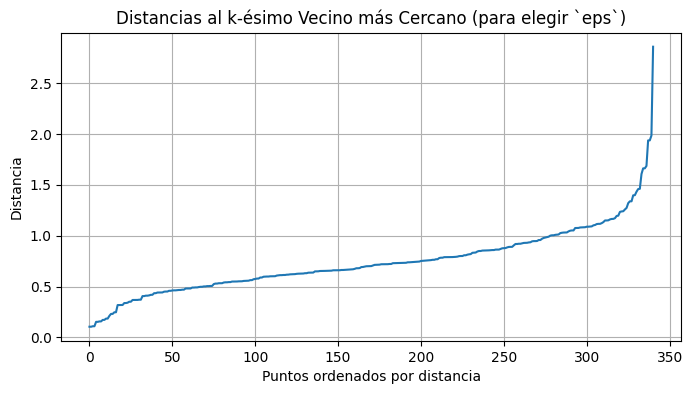

Observa el gráfico de arriba y busca el punto de máxima curvatura ('codo'). Ese valor en el eje Y es un buen candidato para `eps`.


In [66]:
# -----------------------------------------------------------------------------
# PASO 9: MODELADO ALTERNATIVO CON DBSCAN
# -----------------------------------------------------------------------------
print("\n\n--- INICIANDO MODELADO ALTERNATIVO CON DBSCAN ---")

# --- 9.1. Búsqueda del `eps` Óptimo ---
# Una técnica común es calcular la distancia de cada punto a su vecino más
# cercano (k-ésimo vecino) y graficar estas distancias de forma ordenada.
# El "codo" en este gráfico es un buen candidato para `eps`.
# min_samples se suele elegir como 2 * número_de_features

min_samples_dbscan = 2 * scaled_features_df.shape[1]
print(f"\nCalculando `eps` óptimo. Usaremos min_samples = {min_samples_dbscan}")

neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan)
neighbors_fit = neighbors.fit(scaled_features_df)
distances, indices = neighbors_fit.kneighbors(scaled_features_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('Distancias al k-ésimo Vecino más Cercano (para elegir `eps`)')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia')
plt.grid(True)
plt.show()
print("Observa el gráfico de arriba y busca el punto de máxima curvatura ('codo'). Ese valor en el eje Y es un buen candidato para `eps`.")

In [67]:
# --- 9.2. Entrenamiento del Modelo DBSCAN ---
# Basado en el gráfico, elegimos un valor para `eps`.
# El valor de 1.2 se elige basándose en el punto de máxima curvatura ("codo") del gráfico anterior.

eps_optimo = 1.2
print(f"\nEntrenando el modelo DBSCAN con eps = {eps_optimo} y min_samples = {min_samples_dbscan}...")
dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples_dbscan)
dbscan.fit(scaled_features_df)

df_activos['Cluster_DBSCAN'] = dbscan.labels_
print("  - Clusters de DBSCAN asignados a los clientes activos.")


Entrenando el modelo DBSCAN con eps = 1.2 y min_samples = 12...
  - Clusters de DBSCAN asignados a los clientes activos.


In [68]:
# --- 9.3. Análisis de Resultados de DBSCAN ---
print("\n--- ANÁLISIS DE RESULTADOS DE DBSCAN ---")
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"  - Número de clusters encontrados: {n_clusters_}")
print(f"  - Número de clientes clasificados como ruido (outliers): {n_noise_}")

if n_clusters_ > 0:
    silhouette_dbscan = silhouette_score(scaled_features_df, labels)
    print(f"  - Coeficiente de Silueta para DBSCAN: {silhouette_dbscan:.3f}")
else:
    print("  - No se encontraron clusters, no se puede calcular el Coeficiente de Silueta.")



--- ANÁLISIS DE RESULTADOS DE DBSCAN ---
  - Número de clusters encontrados: 3
  - Número de clientes clasificados como ruido (outliers): 127
  - Coeficiente de Silueta para DBSCAN: 0.090




--- INICIANDO MODELADO ALTERNATIVO CON DBSCAN ---

--- 9.1. Ajuste de Hiperparámetros para DBSCAN ---
  - Hiperparámetro 'min_samples' establecido en: 12 (2 * número de features)
  - Generando gráfico k-distance para determinar el hiperparámetro 'eps'...


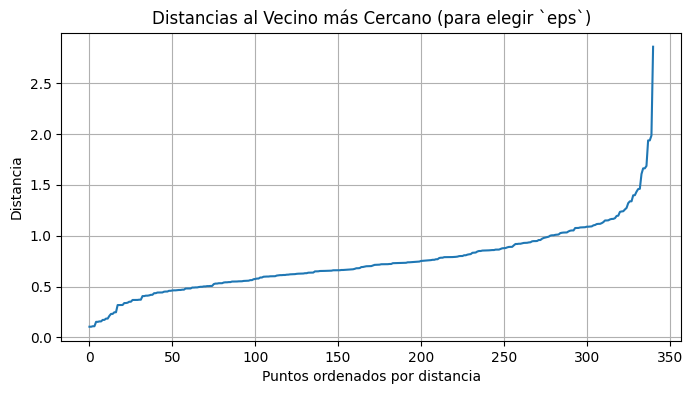

  - Hiperparámetro 'eps' elegido: 1.2 (basado en el análisis del 'codo' del gráfico anterior)

Entrenando el modelo DBSCAN con hiperparámetros ajustados...
  - Clusters de DBSCAN asignados a los clientes activos.

--- ANÁLISIS DE RESULTADOS DE DBSCAN ---
  - Número de clusters encontrados: 3
  - Número de clientes clasificados como ruido (outliers): 127
  - Coeficiente de Silueta para DBSCAN: 0.090


In [69]:
# -----------------------------------------------------------------------------
# PASO 9: MODELADO ALTERNATIVO CON DBSCAN Y AJUSTE DE HIPERPARÁMETROS
# -----------------------------------------------------------------------------
print("\n\n--- INICIANDO MODELADO ALTERNATIVO CON DBSCAN ---")

# --- 9.1. Búsqueda y Justificación de Hiperparámetros para DBSCAN ---
print("\n--- 9.1. Ajuste de Hiperparámetros para DBSCAN ---")

# --- Ajuste de `min_samples` ---
# Una heurística común es establecer min_samples = 2 * número_de_dimensiones (features).
# Esto asegura que los puntos en áreas densas tengan suficientes vecinos.
min_samples_dbscan = 2 * scaled_features_df.shape[1]
print(f"  - Hiperparámetro 'min_samples' establecido en: {min_samples_dbscan} (2 * número de features)")

# --- Búsqueda gráfica de `eps` ---
# Se utiliza el método k-distance plot para encontrar un valor `eps` razonable.
# Buscamos el "codo" en la curva, que representa el punto de máxima curvatura.
print("  - Generando gráfico k-distance para determinar el hiperparámetro 'eps'...")
neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan)
neighbors_fit = neighbors.fit(scaled_features_df)
distances, indices = neighbors_fit.kneighbors(scaled_features_df)
distances = np.sort(distances, axis=0)[:, 1] # Tomamos la distancia al primer vecino

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('Distancias al Vecino más Cercano (para elegir `eps`)')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia')
plt.grid(True)
plt.show()

# --- Elección final de `eps` ---
eps_optimo = 1.2
print(f"  - Hiperparámetro 'eps' elegido: {eps_optimo} (basado en el análisis del 'codo' del gráfico anterior)")


# --- 9.2. Entrenamiento del Modelo DBSCAN con Hiperparámetros Ajustados ---
print(f"\nEntrenando el modelo DBSCAN con hiperparámetros ajustados...")
dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples_dbscan)
dbscan.fit(scaled_features_df)

df_activos['Cluster_DBSCAN'] = dbscan.labels_
print("  - Clusters de DBSCAN asignados a los clientes activos.")

# --- 9.3. Análisis de Resultados de DBSCAN ---
print("\n--- ANÁLISIS DE RESULTADOS DE DBSCAN ---")
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"  - Número de clusters encontrados: {n_clusters_}")
print(f"  - Número de clientes clasificados como ruido (outliers): {n_noise_}")

if n_clusters_ > 0:
    silhouette_dbscan = silhouette_score(scaled_features_df, labels)
    print(f"  - Coeficiente de Silueta para DBSCAN: {silhouette_dbscan:.3f}")
else:
    print("  - No se encontraron clusters, no se puede calcular el Coeficiente de Silueta.")


In [70]:
# Creación del diccionario de métricas para DBSCAN
labels_dbscan = dbscan.labels_
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)

# Solo calculamos métricas si se encuentra al menos un cluster
if n_clusters_dbscan > 0:
    metrics_dbscan = {
        "Modelo": "DBSCAN",
        "Coeficiente de Silueta": silhouette_score(scaled_features_df, labels_dbscan),
        "Índice de Calinski-Harabasz": calinski_harabasz_score(scaled_features_df, labels_dbscan),
        "Índice de Davies-Bouldin": davies_bouldin_score(scaled_features_df, labels_dbscan)
    }
else:
    metrics_dbscan = {
        "Modelo": "DBSCAN",
        "Coeficiente de Silueta": np.nan,
        "Índice de Calinski-Harabasz": np.nan,
        "Índice de Davies-Bouldin": np.nan
    }
print(f"  - Resultados de DBSCAN: {n_clusters_dbscan} clusters y {n_noise_dbscan} puntos de ruido.")
print("  - Métricas de DBSCAN calculadas y almacenadas.")


  - Resultados de DBSCAN: 3 clusters y 127 puntos de ruido.
  - Métricas de DBSCAN calculadas y almacenadas.



--- INICIANDO MODELADO Y EVALUACIÓN CON GAUSSIAN MIXTURE MODELS (GMM) ---

Buscando el número óptimo de componentes para GMM (el BIC más bajo)...


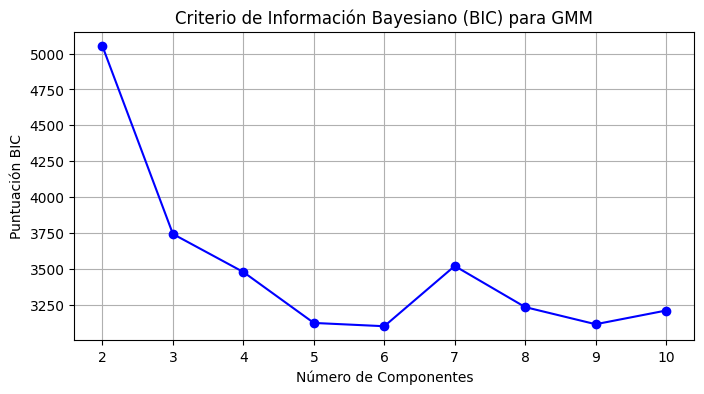

In [71]:
# -----------------------------------------------------------------------------
# PASO 10: BÚSQUEDA DEL NÚMERO ÓPTIMO DE COMPONENTES PARA GMM
# -----------------------------------------------------------------------------
print("\n--- INICIANDO MODELADO Y EVALUACIÓN CON GAUSSIAN MIXTURE MODELS (GMM) ---")

print("\nBuscando el número óptimo de componentes para GMM (el BIC más bajo)...")
# El Criterio de Información Bayesiano (BIC) es una métrica que ayuda a
# seleccionar un modelo entre un conjunto finito de modelos. Un BIC más bajo
# indica un mejor modelo, equilibrando el ajuste del modelo con su complejidad.
n_components = range(2, 11)
bic = []
for i in n_components:
    gmm = GaussianMixture(n_components=i, random_state=42, n_init=10)
    gmm.fit(scaled_features_df)
    bic.append(gmm.bic(scaled_features_df))

# Graficamos los resultados del BIC para visualizar el "codo" o punto más bajo.
plt.figure(figsize=(8, 4))
plt.plot(n_components, bic, 'bo-')
plt.title('Criterio de Información Bayesiano (BIC) para GMM')
plt.xlabel('Número de Componentes')
plt.ylabel('Puntuación BIC')
plt.grid(True)
plt.show()


In [72]:
# -----------------------------------------------------------------------------
# PASO 11: ENTRENAMIENTO DEL MODELO GMM FINAL
# -----------------------------------------------------------------------------
# Seleccionamos el número de componentes que resultó en el BIC más bajo.
n_components_optimo = n_components[np.argmin(bic)]
print(f"\nEntrenando el modelo GMM final con {n_components_optimo} componentes...")

# Entrenamos el modelo final con el número óptimo de componentes.
# n_init=10 ejecuta el algoritmo 10 veces y elige el mejor resultado para evitar óptimos locales.
gmm_final = GaussianMixture(n_components=n_components_optimo, random_state=42, n_init=10)
gmm_final.fit(scaled_features_df)

# Asignamos la etiqueta del cluster predicho a cada cliente en el DataFrame.
df_activos['Cluster_GMM'] = gmm_final.predict(scaled_features_df)
print("  - Clusters de GMM asignados a los clientes activos.")


Entrenando el modelo GMM final con 6 componentes...
  - Clusters de GMM asignados a los clientes activos.


In [73]:
# -----------------------------------------------------------------------------
# PASO 12: EVALUACIÓN DEL MODELO GMM FINAL
# -----------------------------------------------------------------------------
print("\n--- EVALUACIÓN DEL MODELO GMM FINAL ---")

# Calculamos las métricas de evaluación para el modelo GMM entrenado.
silhouette_gmm = silhouette_score(scaled_features_df, df_activos['Cluster_GMM'])
calinski_harabasz_gmm = calinski_harabasz_score(scaled_features_df, df_activos['Cluster_GMM'])
davies_bouldin_gmm = davies_bouldin_score(scaled_features_df, df_activos['Cluster_GMM'])

print(f"  - Coeficiente de Silueta: {silhouette_gmm:.3f}")
print(f"  - Índice de Calinski-Harabasz: {calinski_harabasz_gmm:.2f}")
print(f"  - Índice de Davies-Bouldin: {davies_bouldin_gmm:.3f}")


--- EVALUACIÓN DEL MODELO GMM FINAL ---
  - Coeficiente de Silueta: 0.102
  - Índice de Calinski-Harabasz: 46.04
  - Índice de Davies-Bouldin: 2.813


In [74]:
# -----------------------------------------------------------------------------
# PASO 13: PREPARACIÓN PARA LA TABLA COMPARATIVA
# -----------------------------------------------------------------------------
# Guardamos las métricas en un diccionario para la comparación final.
metrics_gmm = {
    "Modelo": "GMM",
    "Coeficiente de Silueta": silhouette_gmm,
    "Índice de Calinski-Harabasz": calinski_harabasz_gmm,
    "Índice de Davies-Bouldin": davies_bouldin_gmm
}

print("\nEvaluación de GMM completada. Las métricas están listas para la comparación.")


Evaluación de GMM completada. Las métricas están listas para la comparación.


In [75]:
# -----------------------------------------------------------------------------
# PASO 14: TABLA COMPARATIVA FINAL DE MODELOS
# -----------------------------------------------------------------------------
print("\n\n--- TABLA COMPARATIVA DE MODELOS ---")

# Creamos un DataFrame a partir de la lista de diccionarios de métricas.
df_comparacion = pd.DataFrame([metrics_kmeans, metrics_dbscan, metrics_gmm])

# Establecemos 'Modelo' como el índice para una mejor visualización.
print(df_comparacion.set_index('Modelo'))





--- TABLA COMPARATIVA DE MODELOS ---
         Coeficiente de Silueta  Índice de Calinski-Harabasz  \
Modelo                                                         
K-Means                0.198731                   104.121439   
DBSCAN                 0.090138                    33.524374   
GMM                    0.102304                    46.035171   

         Índice de Davies-Bouldin  
Modelo                             
K-Means                  1.544951  
DBSCAN                   1.981633  
GMM                      2.812758  


In [76]:
# -----------------------------------------------------------------------------
# PASO 15: AJUSTE DEL HIPERPARÁMETRO 'covariance_type'
# -----------------------------------------------------------------------------
print("\n--- AJUSTANDO EL HIPERPARÁMETRO 'covariance_type' PARA GMM ---")

covariance_types = ['full', 'tied', 'diag', 'spherical']
results = []

print(f"\nProbando {len(covariance_types)} tipos de covarianza para {n_components_optimo} componentes...")

for cov_type in covariance_types:
    # Entrenamos un modelo GMM para cada tipo de covarianza
    gmm = GaussianMixture(n_components=n_components_optimo,
                          covariance_type=cov_type,
                          random_state=42,
                          n_init=10)
    gmm.fit(scaled_features_df)

    # Calculamos el BIC y lo guardamos
    bic_score = gmm.bic(scaled_features_df)
    results.append({'covariance_type': cov_type, 'BIC_score': bic_score})
    print(f"  - Tipo: '{cov_type}', Puntuación BIC: {bic_score:.2f}")


--- AJUSTANDO EL HIPERPARÁMETRO 'covariance_type' PARA GMM ---

Probando 4 tipos de covarianza para 6 componentes...
  - Tipo: 'full', Puntuación BIC: 3099.98
  - Tipo: 'tied', Puntuación BIC: 5123.31
  - Tipo: 'diag', Puntuación BIC: 2141.86
  - Tipo: 'spherical', Puntuación BIC: 5287.91


In [77]:
# -----------------------------------------------------------------------------
# PASO 16: ANÁLISIS DE RESULTADOS
# -----------------------------------------------------------------------------
# Convertimos los resultados a un DataFrame para una fácil visualización
df_results = pd.DataFrame(results)

# Encontramos la mejor configuración (el BIC más bajo)
best_config = df_results.loc[df_results['BIC_score'].idxmin()]

print("\n--- RESULTADOS DEL AJUSTE ---")
print(df_results)
print("\n---------------------------------------------------------")
print(f"La mejor configuración encontrada es:")
print(f"  - Tipo de covarianza: '{best_config['covariance_type']}'")
print(f"  - Con una puntuación BIC de: {best_config['BIC_score']:.2f}")
print("---------------------------------------------------------")



--- RESULTADOS DEL AJUSTE ---
  covariance_type    BIC_score
0            full  3099.984375
1            tied  5123.313441
2            diag  2141.856456
3       spherical  5287.905742

---------------------------------------------------------
La mejor configuración encontrada es:
  - Tipo de covarianza: 'diag'
  - Con una puntuación BIC de: 2141.86
---------------------------------------------------------


In [78]:
# -----------------------------------------------------------------------------
# PASO 17: RE-ENTRENAR Y EVALUAR EL MODELO GMM OPTIMIZADO
# -----------------------------------------------------------------------------
print("\n--- RE-ENTRENANDO Y EVALUANDO GMM OPTIMIZADO (covariance_type='diag') ---")

# Usamos el tipo de covarianza 'diag' que encontramos en el paso de ajuste
gmm_optimizado = GaussianMixture(n_components=n_components_optimo,
                                 covariance_type='diag', # ¡El hiperparámetro ajustado!
                                 random_state=42,
                                 n_init=10)
gmm_optimizado.fit(scaled_features_df)
labels_gmm_optimizado = gmm_optimizado.predict(scaled_features_df)

# Calculamos las métricas para el modelo optimizado
metrics_gmm_optimizado = {
    "Modelo": "GMM (Optimizado)",
    "Coeficiente de Silueta": silhouette_score(scaled_features_df, labels_gmm_optimizado),
    "Índice de Calinski-Harabasz": calinski_harabasz_score(scaled_features_df, labels_gmm_optimizado),
    "Índice de Davies-Bouldin": davies_bouldin_score(scaled_features_df, labels_gmm_optimizado)
}
print("  - Métricas del GMM optimizado calculadas.")


--- RE-ENTRENANDO Y EVALUANDO GMM OPTIMIZADO (covariance_type='diag') ---
  - Métricas del GMM optimizado calculadas.


In [79]:
# -----------------------------------------------------------------------------
# PASO 18: TABLA COMPARATIVA FINAL DE MODELOS
# -----------------------------------------------------------------------------
print("\n\n--- TABLA COMPARATIVA FINAL DE MODELOS ---")

# Creamos un DataFrame a partir de la lista de diccionarios de métricas.
# Asegúrate de que el diccionario 'metrics_kmeans' existe de los pasos anteriores.
df_comparacion_final = pd.DataFrame([metrics_kmeans, metrics_dbscan, metrics_gmm, metrics_gmm_optimizado])

# Establecemos 'Modelo' como el índice para una mejor visualización.
print(df_comparacion_final.set_index('Modelo'))



--- TABLA COMPARATIVA FINAL DE MODELOS ---
                  Coeficiente de Silueta  Índice de Calinski-Harabasz  \
Modelo                                                                  
K-Means                         0.198731                   104.121439   
DBSCAN                          0.090138                    33.524374   
GMM                             0.102304                    46.035171   
GMM (Optimizado)                0.064131                    48.768602   

                  Índice de Davies-Bouldin  
Modelo                                      
K-Means                           1.544951  
DBSCAN                            1.981633  
GMM                               2.812758  
GMM (Optimizado)                  2.595721  
